In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from skimage.transform import resize
import keras
import cv2
%matplotlib inline

import train_util
import util
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%pwd

'/home/yusuke/tgs-salt-identification'

In [3]:
image_paths = glob('./data/train/images/*.png')

In [4]:
# im_mask_pair_show(image_paths)

In [5]:
# old
# def get_data(data_type='train', size=(101, 101, 3)):
#     base_image_path = './data/{}/images/*.png'.format(data_type)
#     paths = glob(base_image_path)
    
#     X = np.zeros((len(paths), size[0], size[1], size[2]), dtype=np.uint8)
    
# #     for mask
#     base_mask_path = './data/train/masks/'
#     Y = np.zeros((len(paths), size[0], size[1], 1), dtype=np.bool)
#     for i, p in enumerate(paths):
#         im_id = p.split('/')[-1]
#         im = cv2.imread(p)
#         X[i] = im
#         if data_type == 'train':
#             mask_path = base_mask_path + im_id
#             mask = cv2.imread(mask_path)
# #             mask = mask / 255
#             Y[i] = resize(mask[:, :, 0], (101, 101, 1))
        
#     return X, Y

In [6]:
tgt = glob('./data/train/masks/*.png')[0]
im = cv2.imread(tgt)
im / 255
tes = im[: ,:, 1]
resize(tes, (101, 101, 1)).shape


(101, 101, 1)

In [7]:
# X, X_feat, Y = train_util.get_data(size=(128, 128, 3))
X, X_feat, Y, Y_no_salt = train_util.get_data(size=(256, 256, 3))

100%|██████████| 3887/3887 [01:07<00:00, 57.32it/s]


In [8]:
print(X.shape)
print(X_feat.shape)
print(Y.shape)

(3887, 256, 256, 3)
(3887, 1)
(3887, 256, 256, 1)


In [9]:
from sklearn.cross_validation import train_test_split
x_train, x_test, x_feat_train, x_feat_test, y_train, y_test = train_test_split(X, X_feat, Y, test_size=0.1, random_state=43)

In [10]:
x_feat_train, x_feat_test = train_util.norm_X_feat(x_feat_train, x_feat_test)

In [11]:
x_feat_train.shape

(3498, 1)

In [12]:

# for i, arr in enumerate(x_train)


In [13]:
x_feat_train.shape

(3498, 1)

In [14]:
# from keras.preprocessing.image import ImageDataGenerator
# data_gen_args = {
#                              'rotation_range': 90, 
#                              'width_shift_range': 0.2, 
#                              'height_shift_range': 0.2, 
#                              'horizontal_flip': True
# }
# # apply same args for generator
# image_datagen = ImageDataGenerator(**data_gen_args)
# feature_datagen = ImageDataGenerator()
# mask_datagen = ImageDataGenerator(**data_gen_args)

# # set same seed number and apply it to X and Y (mask)
# seed = 1
# image_datagen.fit(x_train, augment=True, seed=seed)
# # feature_datagen.fit(x_feat_train, seed=seed)
# mask_datagen.fit(y_train, augment=True, seed=seed)

# image_generator = image_datagen.flow(x_train, seed=seed, batch_size=32, shuffle=True)
# # feature_generator = feature_datagen.flow(x_feat_train, seed=seed, batch_size=32, shuffle=True)
# mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=32, shuffle=True)

# # train_gen = zip(image_generator, feature_generator,  mask_generator)
# train_gen = zip(np.ndarray.flatten(image_generator,  mask_generator))
# # train_gen = datagen.flow(x_train, y_train, batch_size=32, shuffle=True)
# val_gen = (x_test, x_feat_test, y_test)

In [15]:
from keras.preprocessing.image import ImageDataGenerator
def make_train_gen(x_train, x_feat_train, y_train, batch_size=16, seed = None):

    data_gen_args = {
#                                  'rotation_range': 90, 
#                                  'width_shift_range': 0.2, 
#                                  'height_shift_range': 0.2, 
                                 'horizontal_flip': True,
                                 'vertical_flip': True
    }
    # apply same args for generator
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    # set same seed number and apply it to X and Y (mask)
#     image_datagen.fit(x_train, augment=True, seed=seed)
    # feature_datagen.fit(x_feat_train, seed=seed)
#     mask_datagen.fit(y_train, augment=True, seed=seed)

#     image_generator = image_datagen.flow(x_train, seed=seed, batch_size=32, shuffle=True)
    # feature_generator = feature_datagen.flow(x_feat_train, seed=seed, batch_size=32, shuffle=True)
#     mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=32, shuffle=True)

    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    while True:
        seed = np.random.choice(range(9999))
        batch_count = x_train.shape[0]/batch_size
        batch_id = np.random.permutation(range(0, x_train.shape[0] - batch_size, batch_size))
        for c_idx in batch_id:
            g_x = image_datagen.flow(x_train[c_idx:(c_idx+batch_size)], batch_size=batch_size, seed=seed, shuffle=False)
            g_y = mask_datagen.flow(y_train[c_idx:(c_idx+batch_size)], batch_size=batch_size, seed=seed, shuffle=False)
            yield [next(g_x), x_feat_train[c_idx:(c_idx+batch_size)]], next(g_y)

In [16]:
train_gen = make_train_gen(x_train, x_feat_train, y_train, batch_size=32, seed=1)
val_gen = ([x_test, x_feat_test], y_test)

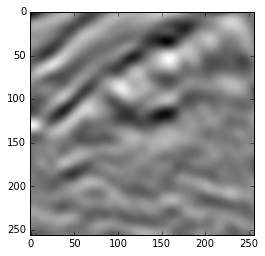

In [17]:
# it looks like train_gen generate ((train_image, feature), mask) * batch
tgt = 15

batch = train_gen.__next__()
plt.imshow(batch[0][0][tgt])

In [18]:
batch[0][1][tgt]

array([0.97150654], dtype=float32)

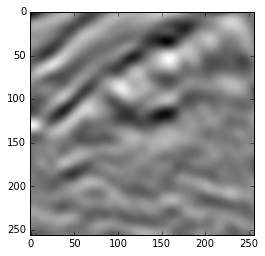

In [19]:
plt.imshow(batch[0][0][tgt])

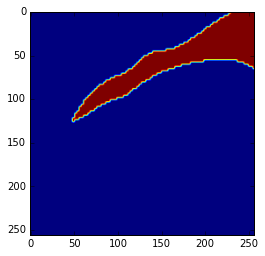

In [20]:
plt.imshow(np.squeeze(batch[1][tgt]))

In [21]:
train_gen

<generator object make_train_gen at 0x7f36beda02b0>

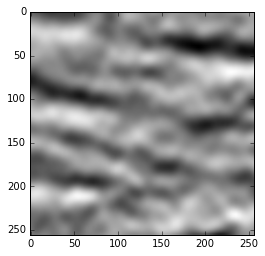

In [22]:
tgt = 4
plt.imshow(x_train[tgt])

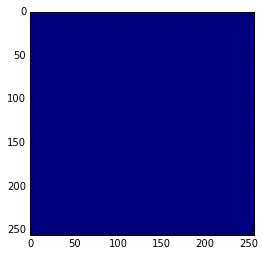

In [23]:
plt.imshow(np.squeeze(y_train[tgt]))

In [24]:
# seed = np.random.choice(range(9999))
# samplegen = ImageDataGenerator(rotation_range=180)
# gx = samplegen.flow(x_train[tgt].reshape(1, 128, 128, 3), batch_size=10, seed=seed)
# gy = samplegen.flow(y_train[tgt].reshape(1, 128, 128, 1), batch_size=10, seed=seed)
# batchx = gx.__next__()
# batchy = gy.__next__()
# plt.imshow(batchx[0])

In [25]:
# plt.imshow(np.squeeze(batchy[0]))

In [26]:
# unet_m.summary()

In [30]:
# unet_m = util.unet_model(min_filter_num=32)
unet_m = util.unet_model(min_filter_num=16, with_vec=True, input_shape=(256, 256, 3))
from keras.models import load_model
from keras.optimizers import Adam
# unet_m = load_model('./log/2018_0727_1808/best_weights.hdf5', custom_objects={'mean_iou': train_util.mean_iou})

In [ ]:
# train_util.train(unet_m, train_gen, val_gen, loss=train_util.dice_p_bce, metrics=[train_util.dice_coef, 'binary_accuracy', train_util.true_positive_rate], epochs=3000, steps_per_epoch=32, optimizer=Adam(1e-4, decay=1e-6))
rmsprop = keras.optimizers.RMSprop(lr=1e-4)
train_util.train(unet_m, train_gen, val_gen, metrics=[train_util.mean_iou], epochs=3000, steps_per_epoch=32, optimizer=rmsprop)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
encoder_block_1 (Conv2D)        (None, 256, 256, 16) 448         input_layer[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           encoder_block_1[0][0]            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout_1[0][0]                  
__________________________________________________________________________________________________
max_poolin

Epoch 1/3000
 - 39s - loss: 0.6896 - mean_iou: 0.3601 - val_loss: 0.5757 - val_mean_iou: 0.3944
Finished epoch: 0
{'loss': 0.689636617898941, 'mean_iou': 0.36011746898293495, 'val_loss': 0.5757423881393472, 'val_mean_iou': 0.3943758747877989}

Epoch 00001: val_loss improved from inf to 0.57574, saving model to ./log/2018_0729_0020/best_weights.hdf5
Epoch 2/3000
 - 34s - loss: 0.5805 - mean_iou: 0.3846 - val_loss: 0.5856 - val_mean_iou: 0.3843
Finished epoch: 5
{'loss': 0.5804694052785635, 'mean_iou': 0.3846419835463166, 'val_loss': 0.5855620572376987, 'val_mean_iou': 0.3843196254309774}

Epoch 00006: val_loss did not improve
Epoch 7/3000
 - 34s - loss: 0.5444 - mean_iou: 0.3843 - val_loss: 0.5805 - val_mean_iou: 0.3848
Finished epoch: 6
{'loss': 0.5443769907578826, 'mean_iou': 0.3843257948756218, 'val_loss': 0.5804968834842692, 'val_mean_iou': 0.3847508975963053}

Epoch 00007: val_loss did not improve
Epoch 8/3000
 - 34s - loss: 0.5676 - mean_iou: 0.3846 - val_loss: 0.5812 - val_mean_i

Finished epoch: 32
{'loss': 0.35091025196015835, 'mean_iou': 0.4196337554603815, 'val_loss': 1.085631623059741, 'val_mean_iou': 0.4209284769385517}

Epoch 00033: val_loss did not improve
Epoch 34/3000
 - 34s - loss: 0.3513 - mean_iou: 0.4217 - val_loss: 1.0142 - val_mean_iou: 0.4227
Finished epoch: 33
{'loss': 0.3513334980234504, 'mean_iou': 0.42173473816365004, 'val_loss': 1.0142463687759438, 'val_mean_iou': 0.42267061444358534}

Epoch 00034: val_loss did not improve
Epoch 35/3000
 - 34s - loss: 0.3460 - mean_iou: 0.4236 - val_loss: 0.6725 - val_mean_iou: 0.4246
Finished epoch: 34
{'loss': 0.3460115324705839, 'mean_iou': 0.42358542513102293, 'val_loss': 0.6724516842849457, 'val_mean_iou': 0.4246086472104325}

Epoch 00035: val_loss did not improve
Epoch 36/3000
 - 34s - loss: 0.3382 - mean_iou: 0.4258 - val_loss: 1.1110 - val_mean_iou: 0.4272
Finished epoch: 35
{'loss': 0.3381546111777425, 'mean_iou': 0.42577842622995377, 'val_loss': 1.110980751581854, 'val_mean_iou': 0.427154012618150

Finished epoch: 61
{'loss': 0.2581701511517167, 'mean_iou': 0.47878740821033716, 'val_loss': 1.1610951359290391, 'val_mean_iou': 0.47985350082037076}

Epoch 00062: val_loss did not improve
Epoch 63/3000
 - 34s - loss: 0.2473 - mean_iou: 0.4806 - val_loss: 1.0750 - val_mean_iou: 0.4815
Finished epoch: 62
{'loss': 0.24727539997547865, 'mean_iou': 0.48055828642100096, 'val_loss': 1.0750306703744021, 'val_mean_iou': 0.4815248168985764}

Epoch 00063: val_loss did not improve
Epoch 64/3000
 - 34s - loss: 0.2896 - mean_iou: 0.4822 - val_loss: 0.9073 - val_mean_iou: 0.4832
Finished epoch: 63
{'loss': 0.28964551351964474, 'mean_iou': 0.48218565061688423, 'val_loss': 0.9072840474258658, 'val_mean_iou': 0.48321932140536666}

Epoch 00064: val_loss did not improve
Epoch 65/3000
 - 34s - loss: 0.2672 - mean_iou: 0.4840 - val_loss: 1.5426 - val_mean_iou: 0.4850
Finished epoch: 64
{'loss': 0.26718552922829986, 'mean_iou': 0.4839928103610873, 'val_loss': 1.5425819360811484, 'val_mean_iou': 0.4849697140

Finished epoch: 90
{'loss': 0.2261216309852898, 'mean_iou': 0.5230702366679907, 'val_loss': 0.6132674546658533, 'val_mean_iou': 0.5239210973055626}

Epoch 00091: val_loss did not improve
Epoch 92/3000
 - 34s - loss: 0.2342 - mean_iou: 0.5243 - val_loss: 0.4670 - val_mean_iou: 0.5249
Finished epoch: 91
{'loss': 0.23416713229380548, 'mean_iou': 0.5242982190102339, 'val_loss': 0.46701789101475616, 'val_mean_iou': 0.5249450105627889}

Epoch 00092: val_loss did not improve
Epoch 93/3000
 - 34s - loss: 0.2248 - mean_iou: 0.5257 - val_loss: 0.7692 - val_mean_iou: 0.5262
Finished epoch: 92
{'loss': 0.22477720398455858, 'mean_iou': 0.5256619285792112, 'val_loss': 0.7692332240180675, 'val_mean_iou': 0.5261751258587776}

Epoch 00093: val_loss did not improve
Epoch 94/3000
 - 34s - loss: 0.2328 - mean_iou: 0.5266 - val_loss: 0.6580 - val_mean_iou: 0.5272
Finished epoch: 93
{'loss': 0.23277306277304888, 'mean_iou': 0.5265770237892866, 'val_loss': 0.6579724133474355, 'val_mean_iou': 0.52724004787773

 - 34s - loss: 0.2019 - mean_iou: 0.5542 - val_loss: 0.9843 - val_mean_iou: 0.5547
Finished epoch: 119
{'loss': 0.20188896893523633, 'mean_iou': 0.5542265251278877, 'val_loss': 0.9842568160942097, 'val_mean_iou': 0.5546514330608986}

Epoch 00120: val_loss did not improve
Epoch 121/3000
 - 34s - loss: 0.2055 - mean_iou: 0.5549 - val_loss: 0.6136 - val_mean_iou: 0.5554
Finished epoch: 120
{'loss': 0.2055479078553617, 'mean_iou': 0.5548650771379471, 'val_loss': 0.6135602351325949, 'val_mean_iou': 0.5553538253803793}

Epoch 00121: val_loss did not improve
Epoch 122/3000
 - 34s - loss: 0.2057 - mean_iou: 0.5558 - val_loss: 0.7479 - val_mean_iou: 0.5564
Finished epoch: 121
{'loss': 0.20574740902520716, 'mean_iou': 0.5557874999940395, 'val_loss': 0.7479391076570918, 'val_mean_iou': 0.5563801097992453}

Epoch 00122: val_loss did not improve
Epoch 123/3000
 - 34s - loss: 0.2009 - mean_iou: 0.5567 - val_loss: 0.6058 - val_mean_iou: 0.5573
Finished epoch: 122
{'loss': 0.2009080876596272, 'mean_io

 - 34s - loss: 0.1843 - mean_iou: 0.5775 - val_loss: 0.4248 - val_mean_iou: 0.5780
Finished epoch: 148
{'loss': 0.18429624428972602, 'mean_iou': 0.5774914138019085, 'val_loss': 0.4247602873259155, 'val_mean_iou': 0.5779880107521704}

Epoch 00149: val_loss improved from 0.46144 to 0.42476, saving model to ./log/2018_0729_0020/best_weights.hdf5
Epoch 150/3000
 - 34s - loss: 0.1753 - mean_iou: 0.5785 - val_loss: 0.5577 - val_mean_iou: 0.5789
Finished epoch: 149
{'loss': 0.17525859060697258, 'mean_iou': 0.5784580856561661, 'val_loss': 0.5577144904737301, 'val_mean_iou': 0.5789215964645836}

Epoch 00150: val_loss did not improve
Epoch 151/3000
 - 34s - loss: 0.1853 - mean_iou: 0.5793 - val_loss: 0.4451 - val_mean_iou: 0.5798
Finished epoch: 150
{'loss': 0.18526574317365885, 'mean_iou': 0.5793107934296131, 'val_loss': 0.44511555583434115, 'val_mean_iou': 0.5798459970859146}

Epoch 00151: val_loss did not improve
Epoch 152/3000
 - 34s - loss: 0.1813 - mean_iou: 0.5802 - val_loss: 0.6016 - val

 - 34s - loss: 0.1673 - mean_iou: 0.5994 - val_loss: 0.4015 - val_mean_iou: 0.5998
Finished epoch: 176
{'loss': 0.16729395184665918, 'mean_iou': 0.5993935484439135, 'val_loss': 0.4015062862006435, 'val_mean_iou': 0.5997750100255932}

Epoch 00177: val_loss did not improve
Epoch 178/3000
 - 34s - loss: 0.1776 - mean_iou: 0.6001 - val_loss: 0.5448 - val_mean_iou: 0.6005
Finished epoch: 177
{'loss': 0.17764651449397206, 'mean_iou': 0.6001231372356415, 'val_loss': 0.5447827738477515, 'val_mean_iou': 0.6004781088669686}

Epoch 00178: val_loss did not improve
Epoch 179/3000
 - 34s - loss: 0.1754 - mean_iou: 0.6008 - val_loss: 0.5585 - val_mean_iou: 0.6011
Finished epoch: 178
{'loss': 0.17539536417461932, 'mean_iou': 0.6007704455405474, 'val_loss': 0.5584784447380694, 'val_mean_iou': 0.6010978263264144}

Epoch 00179: val_loss did not improve
Epoch 180/3000
 - 34s - loss: 0.1638 - mean_iou: 0.6014 - val_loss: 0.3292 - val_mean_iou: 0.6019
Finished epoch: 179
{'loss': 0.16380696604028344, 'mean_

 - 34s - loss: 0.1538 - mean_iou: 0.6234 - val_loss: 0.2955 - val_mean_iou: 0.6238
Finished epoch: 204
{'loss': 0.1537547716870904, 'mean_iou': 0.6234124638140202, 'val_loss': 0.29545997891450604, 'val_mean_iou': 0.6238273818879018}

Epoch 00205: val_loss did not improve
Epoch 206/3000
 - 34s - loss: 0.1643 - mean_iou: 0.6243 - val_loss: 0.4593 - val_mean_iou: 0.6247
Finished epoch: 205
{'loss': 0.1643385108327493, 'mean_iou': 0.6242789477109909, 'val_loss': 0.4592931167938409, 'val_mean_iou': 0.6246712373277522}

Epoch 00206: val_loss did not improve
Epoch 207/3000
 - 34s - loss: 0.1475 - mean_iou: 0.6251 - val_loss: 0.4523 - val_mean_iou: 0.6255
Finished epoch: 206
{'loss': 0.14748875563964248, 'mean_iou': 0.6251233629882336, 'val_loss': 0.4522748741208741, 'val_mean_iou': 0.6255244710757983}

Epoch 00207: val_loss did not improve
Epoch 208/3000
 - 34s - loss: 0.1631 - mean_iou: 0.6259 - val_loss: 0.2933 - val_mean_iou: 0.6262
Finished epoch: 207
{'loss': 0.16306972550228238, 'mean_i

Finished epoch: 232
{'loss': 0.15522463200613856, 'mean_iou': 0.6459151431918144, 'val_loss': 0.332141306260864, 'val_mean_iou': 0.6462541386523406}

Epoch 00233: val_loss did not improve
Epoch 234/3000
 - 34s - loss: 0.1384 - mean_iou: 0.6466 - val_loss: 0.2594 - val_mean_iou: 0.6470
Finished epoch: 233
{'loss': 0.13843156257644296, 'mean_iou': 0.6466264799237251, 'val_loss': 0.25937788826257835, 'val_mean_iou': 0.6469836725367372}

Epoch 00234: val_loss did not improve
Epoch 235/3000
 - 34s - loss: 0.1499 - mean_iou: 0.6474 - val_loss: 0.2501 - val_mean_iou: 0.6477
Finished epoch: 234
{'loss': 0.14993145945481956, 'mean_iou': 0.6473705004900694, 'val_loss': 0.25014486826554055, 'val_mean_iou': 0.6477344118843961}

Epoch 00235: val_loss did not improve
Epoch 236/3000
 - 34s - loss: 0.1417 - mean_iou: 0.6481 - val_loss: 0.2776 - val_mean_iou: 0.6485
Finished epoch: 235
{'loss': 0.14172535354737192, 'mean_iou': 0.6481137182563543, 'val_loss': 0.27758705250171894, 'val_mean_iou': 0.64847

 - 34s - loss: 0.1344 - mean_iou: 0.6651 - val_loss: 0.2454 - val_mean_iou: 0.6654
Finished epoch: 261
{'loss': 0.13442987413145602, 'mean_iou': 0.6650961730629206, 'val_loss': 0.24537938070940787, 'val_mean_iou': 0.6654140002316865}

Epoch 00262: val_loss did not improve
Epoch 263/3000
 - 34s - loss: 0.1264 - mean_iou: 0.6658 - val_loss: 0.2840 - val_mean_iou: 0.6661
Finished epoch: 262
{'loss': 0.1263675489462912, 'mean_iou': 0.6657531317323446, 'val_loss': 0.2840154615343383, 'val_mean_iou': 0.6660699292749243}

Epoch 00263: val_loss did not improve
Epoch 264/3000
 - 34s - loss: 0.1177 - mean_iou: 0.6664 - val_loss: 0.6196 - val_mean_iou: 0.6667
Finished epoch: 263
{'loss': 0.11768531228881329, 'mean_iou': 0.6663939133286476, 'val_loss': 0.6195930634412177, 'val_mean_iou': 0.6666972327661391}

Epoch 00264: val_loss did not improve
Epoch 265/3000
 - 34s - loss: 0.1409 - mean_iou: 0.6669 - val_loss: 0.2454 - val_mean_iou: 0.6672
Finished epoch: 264
{'loss': 0.1409387671155855, 'mean_i

 - 34s - loss: 0.1166 - mean_iou: 0.6812 - val_loss: 0.7191 - val_mean_iou: 0.6814
Finished epoch: 290
{'loss': 0.11659486405551434, 'mean_iou': 0.6811819523572922, 'val_loss': 0.7191216104441253, 'val_mean_iou': 0.6813928841931655}

Epoch 00291: val_loss did not improve
Epoch 292/3000
 - 34s - loss: 0.1278 - mean_iou: 0.6816 - val_loss: 0.2110 - val_mean_iou: 0.6818
Finished epoch: 291
{'loss': 0.12781017180532217, 'mean_iou': 0.6816078349947929, 'val_loss': 0.2109981498616367, 'val_mean_iou': 0.6818405961316165}

Epoch 00292: val_loss did not improve
Epoch 293/3000
 - 34s - loss: 0.1329 - mean_iou: 0.6821 - val_loss: 0.3588 - val_mean_iou: 0.6823
Finished epoch: 292
{'loss': 0.13287439558189362, 'mean_iou': 0.6820867583155632, 'val_loss': 0.35884018077641955, 'val_mean_iou': 0.6823017269296328}

Epoch 00293: val_loss did not improve
Epoch 294/3000
 - 34s - loss: 0.1146 - mean_iou: 0.6826 - val_loss: 0.4512 - val_mean_iou: 0.6828
Finished epoch: 293
{'loss': 0.11459761171136051, 'mean

 - 34s - loss: 0.1369 - mean_iou: 0.6941 - val_loss: 0.1869 - val_mean_iou: 0.6943
Finished epoch: 319
{'loss': 0.13685966096818447, 'mean_iou': 0.6941480450332165, 'val_loss': 0.1868853765542219, 'val_mean_iou': 0.6943470628831564}

Epoch 00320: val_loss did not improve
Epoch 321/3000
 - 34s - loss: 0.1191 - mean_iou: 0.6946 - val_loss: 0.3155 - val_mean_iou: 0.6948
Finished epoch: 320
{'loss': 0.11907444638200104, 'mean_iou': 0.6945730596780777, 'val_loss': 0.31550586874809855, 'val_mean_iou': 0.6947611312939759}

Epoch 00321: val_loss did not improve
Epoch 322/3000
 - 34s - loss: 0.1117 - mean_iou: 0.6950 - val_loss: 0.3487 - val_mean_iou: 0.6952
Finished epoch: 321
{'loss': 0.11171105888206512, 'mean_iou': 0.6949582602828741, 'val_loss': 0.34869864981401244, 'val_mean_iou': 0.6951842392318353}

Epoch 00322: val_loss did not improve
Epoch 323/3000
 - 34s - loss: 0.1316 - mean_iou: 0.6954 - val_loss: 0.3000 - val_mean_iou: 0.6956
Finished epoch: 322
{'loss': 0.1316124126315117, 'mean

 - 34s - loss: 0.1102 - mean_iou: 0.7057 - val_loss: 0.3475 - val_mean_iou: 0.7059
Finished epoch: 348
{'loss': 0.11019512789789587, 'mean_iou': 0.705692445859313, 'val_loss': 0.3475069790159216, 'val_mean_iou': 0.7058688805158463}

Epoch 00349: val_loss did not improve
Epoch 350/3000
 - 34s - loss: 0.1208 - mean_iou: 0.7061 - val_loss: 0.2684 - val_mean_iou: 0.7063
Finished epoch: 349
{'loss': 0.1207595543237403, 'mean_iou': 0.7060664519667625, 'val_loss': 0.2683823971714642, 'val_mean_iou': 0.7062525697109938}

Epoch 00350: val_loss did not improve
Epoch 351/3000
 - 34s - loss: 0.1118 - mean_iou: 0.7065 - val_loss: 0.4462 - val_mean_iou: 0.7066
Finished epoch: 350
{'loss': 0.11179520399309695, 'mean_iou': 0.7064524628221989, 'val_loss': 0.4461695987798254, 'val_mean_iou': 0.7066174466689632}

Epoch 00351: val_loss did not improve
Epoch 352/3000
 - 34s - loss: 0.1006 - mean_iou: 0.7068 - val_loss: 0.4914 - val_mean_iou: 0.7070
Finished epoch: 351
{'loss': 0.10055022686719894, 'mean_io

 - 34s - loss: 0.1188 - mean_iou: 0.7158 - val_loss: 0.4769 - val_mean_iou: 0.7160
Finished epoch: 377
{'loss': 0.11884489399380982, 'mean_iou': 0.7158456686884165, 'val_loss': 0.4768890843255048, 'val_mean_iou': 0.7159926269232154}

Epoch 00378: val_loss did not improve
Epoch 379/3000
 - 34s - loss: 0.0916 - mean_iou: 0.7162 - val_loss: 0.5915 - val_mean_iou: 0.7163
Finished epoch: 378
{'loss': 0.09160684060771018, 'mean_iou': 0.7161680217832327, 'val_loss': 0.591536649241852, 'val_mean_iou': 0.716336708755297}

Epoch 00379: val_loss did not improve
Epoch 380/3000
 - 34s - loss: 0.1283 - mean_iou: 0.7165 - val_loss: 0.2654 - val_mean_iou: 0.7166
Finished epoch: 379
{'loss': 0.12832551985047758, 'mean_iou': 0.7164866533130407, 'val_loss': 0.2654414674731637, 'val_mean_iou': 0.716619741640851}

Epoch 00380: val_loss did not improve
Epoch 381/3000
 - 34s - loss: 0.0984 - mean_iou: 0.7168 - val_loss: 0.3666 - val_mean_iou: 0.7170
Finished epoch: 380
{'loss': 0.09839830547571182, 'mean_iou

 - 34s - loss: 0.1014 - mean_iou: 0.7251 - val_loss: 0.5105 - val_mean_iou: 0.7252
Finished epoch: 406
{'loss': 0.10141236311756074, 'mean_iou': 0.7250572014600039, 'val_loss': 0.5105028537061344, 'val_mean_iou': 0.725178215681434}

Epoch 00407: val_loss did not improve
Epoch 408/3000
 - 34s - loss: 0.1145 - mean_iou: 0.7253 - val_loss: 0.2673 - val_mean_iou: 0.7254
Finished epoch: 407
{'loss': 0.11452632676810026, 'mean_iou': 0.7252808809280396, 'val_loss': 0.26728790943872344, 'val_mean_iou': 0.7254300106766904}

Epoch 00408: val_loss did not improve
Epoch 409/3000
 - 34s - loss: 0.0998 - mean_iou: 0.7256 - val_loss: 0.5938 - val_mean_iou: 0.7258
Finished epoch: 408
{'loss': 0.09977736847940832, 'mean_iou': 0.725619999691844, 'val_loss': 0.593825336516976, 'val_mean_iou': 0.7257700887314764}

Epoch 00409: val_loss did not improve
Epoch 410/3000
 - 34s - loss: 0.1048 - mean_iou: 0.7259 - val_loss: 0.3092 - val_mean_iou: 0.7261
Finished epoch: 409
{'loss': 0.10483375587500632, 'mean_io

 - 34s - loss: 0.1002 - mean_iou: 0.7333 - val_loss: 0.5087 - val_mean_iou: 0.7335
Finished epoch: 435
{'loss': 0.10021723981481045, 'mean_iou': 0.7333241272717714, 'val_loss': 0.5086514253772623, 'val_mean_iou': 0.7334660095543358}

Epoch 00436: val_loss did not improve
Epoch 437/3000
 - 34s - loss: 0.0919 - mean_iou: 0.7336 - val_loss: 0.4538 - val_mean_iou: 0.7337
Finished epoch: 436
{'loss': 0.09194468113128096, 'mean_iou': 0.7336125299334526, 'val_loss': 0.45376474929346217, 'val_mean_iou': 0.733742466316125}

Epoch 00437: val_loss did not improve
Epoch 438/3000
 - 34s - loss: 0.0900 - mean_iou: 0.7339 - val_loss: 0.3232 - val_mean_iou: 0.7340
Finished epoch: 437
{'loss': 0.08999128511641175, 'mean_iou': 0.7338827941566706, 'val_loss': 0.32321919991148773, 'val_mean_iou': 0.7340300245579227}

Epoch 00438: val_loss did not improve
Epoch 439/3000
 - 34s - loss: 0.1191 - mean_iou: 0.7342 - val_loss: 0.3260 - val_mean_iou: 0.7343
Finished epoch: 438
{'loss': 0.11908520571887493, 'mean

 - 34s - loss: 0.0841 - mean_iou: 0.7409 - val_loss: 0.4142 - val_mean_iou: 0.7410
Finished epoch: 464
{'loss': 0.08409307186957449, 'mean_iou': 0.740859491750598, 'val_loss': 0.4142009655928244, 'val_mean_iou': 0.7409968317934051}

Epoch 00465: val_loss did not improve
Epoch 466/3000
 - 34s - loss: 0.1078 - mean_iou: 0.7411 - val_loss: 0.3854 - val_mean_iou: 0.7412
Finished epoch: 465
{'loss': 0.10780317091848701, 'mean_iou': 0.7411110624670982, 'val_loss': 0.38544820593837603, 'val_mean_iou': 0.7412108677824849}

Epoch 00466: val_loss did not improve
Epoch 467/3000
 - 34s - loss: 0.1013 - mean_iou: 0.7413 - val_loss: 0.3880 - val_mean_iou: 0.7414
Finished epoch: 466
{'loss': 0.10133539757225662, 'mean_iou': 0.7413250170648098, 'val_loss': 0.3879841617224762, 'val_mean_iou': 0.741436628725351}

Epoch 00467: val_loss did not improve
Epoch 468/3000
 - 34s - loss: 0.0909 - mean_iou: 0.7416 - val_loss: 0.2554 - val_mean_iou: 0.7417
Finished epoch: 467
{'loss': 0.09085693128872663, 'mean_i

 - 34s - loss: 0.1002 - mean_iou: 0.7479 - val_loss: 0.3849 - val_mean_iou: 0.7480
Finished epoch: 493
{'loss': 0.10018556623253971, 'mean_iou': 0.7479027453809977, 'val_loss': 0.38488399461486344, 'val_mean_iou': 0.7480128029011822}

Epoch 00494: val_loss did not improve
Epoch 495/3000
 - 34s - loss: 0.0816 - mean_iou: 0.7481 - val_loss: 0.6847 - val_mean_iou: 0.7482
Finished epoch: 494
{'loss': 0.08161902346182615, 'mean_iou': 0.7481359876692295, 'val_loss': 0.6847184706469734, 'val_mean_iou': 0.7482471395580812}

Epoch 00495: val_loss did not improve
Epoch 496/3000
 - 34s - loss: 0.0957 - mean_iou: 0.7484 - val_loss: 0.3311 - val_mean_iou: 0.7485
Finished epoch: 495
{'loss': 0.09570934809744358, 'mean_iou': 0.7483562976121902, 'val_loss': 0.3311118137206317, 'val_mean_iou': 0.7484599189464108}

Epoch 00496: val_loss did not improve
Epoch 497/3000
 - 34s - loss: 0.0995 - mean_iou: 0.7486 - val_loss: 0.5585 - val_mean_iou: 0.7487
Finished epoch: 496
{'loss': 0.09948572947178036, 'mean

 - 33s - loss: 0.0897 - mean_iou: 0.7544 - val_loss: 0.2699 - val_mean_iou: 0.7545
Finished epoch: 522
{'loss': 0.08967189583927393, 'mean_iou': 0.7543577067553997, 'val_loss': 0.26985520089002074, 'val_mean_iou': 0.754474291458228}

Epoch 00523: val_loss did not improve
Epoch 524/3000
 - 34s - loss: 0.0858 - mean_iou: 0.7546 - val_loss: 0.5799 - val_mean_iou: 0.7547
Finished epoch: 523
{'loss': 0.08583743474446237, 'mean_iou': 0.7545852437615395, 'val_loss': 0.579944546968894, 'val_mean_iou': 0.7546805244485026}

Epoch 00524: val_loss did not improve
Epoch 525/3000
 - 34s - loss: 0.0895 - mean_iou: 0.7548 - val_loss: 0.4360 - val_mean_iou: 0.7549
Finished epoch: 524
{'loss': 0.08954986452590674, 'mean_iou': 0.7547779604792595, 'val_loss': 0.4359864811855907, 'val_mean_iou': 0.7548779266046068}

Epoch 00525: val_loss did not improve
Epoch 526/3000
 - 34s - loss: 0.0793 - mean_iou: 0.7550 - val_loss: 0.3999 - val_mean_iou: 0.7551
Finished epoch: 525
{'loss': 0.07931057747919112, 'mean_i

 - 34s - loss: 0.0878 - mean_iou: 0.7603 - val_loss: 0.5768 - val_mean_iou: 0.7604
Finished epoch: 551
{'loss': 0.08775520540075377, 'mean_iou': 0.7603292278945446, 'val_loss': 0.5767799764871597, 'val_mean_iou': 0.760424469307946}

Epoch 00552: val_loss did not improve
Epoch 553/3000
 - 34s - loss: 0.0859 - mean_iou: 0.7605 - val_loss: 0.5086 - val_mean_iou: 0.7606
Finished epoch: 552
{'loss': 0.08588037977460772, 'mean_iou': 0.7605072595179081, 'val_loss': 0.5086335897311607, 'val_mean_iou': 0.7605986029752423}

Epoch 00553: val_loss did not improve
Epoch 554/3000
 - 34s - loss: 0.0843 - mean_iou: 0.7607 - val_loss: 0.4230 - val_mean_iou: 0.7608
Finished epoch: 553
{'loss': 0.08425349032040685, 'mean_iou': 0.7607024032622576, 'val_loss': 0.4230152903876452, 'val_mean_iou': 0.7608152726009143}

Epoch 00554: val_loss did not improve
Epoch 555/3000
 - 34s - loss: 0.0830 - mean_iou: 0.7609 - val_loss: 0.4844 - val_mean_iou: 0.7610
Finished epoch: 554
{'loss': 0.08302423579152673, 'mean_i

 - 34s - loss: 0.0826 - mean_iou: 0.7658 - val_loss: 0.3347 - val_mean_iou: 0.7659
Finished epoch: 580
{'loss': 0.08263127878308296, 'mean_iou': 0.7657998837530613, 'val_loss': 0.3347354506724215, 'val_mean_iou': 0.7658962120127248}

Epoch 00581: val_loss did not improve
Epoch 582/3000
 - 34s - loss: 0.0756 - mean_iou: 0.7660 - val_loss: 0.5841 - val_mean_iou: 0.7661
Finished epoch: 581
{'loss': 0.07560347020626068, 'mean_iou': 0.7660175021737814, 'val_loss': 0.5840972915081102, 'val_mean_iou': 0.7661074448980218}

Epoch 00582: val_loss did not improve
Epoch 583/3000
 - 34s - loss: 0.0732 - mean_iou: 0.7662 - val_loss: 0.3733 - val_mean_iou: 0.7663
Finished epoch: 582
{'loss': 0.07317530224099755, 'mean_iou': 0.76618960686028, 'val_loss': 0.37332474200921684, 'val_mean_iou': 0.7662811332925733}

Epoch 00583: val_loss did not improve
Epoch 584/3000
 - 34s - loss: 0.0739 - mean_iou: 0.7664 - val_loss: 0.4771 - val_mean_iou: 0.7665
Finished epoch: 583
{'loss': 0.07392105227336287, 'mean_i

 - 34s - loss: 0.0679 - mean_iou: 0.7711 - val_loss: 0.4233 - val_mean_iou: 0.7711
Finished epoch: 609
{'loss': 0.06787529960274696, 'mean_iou': 0.7710653021931648, 'val_loss': 0.4232564196229977, 'val_mean_iou': 0.7711484306575707}

Epoch 00610: val_loss did not improve
Epoch 611/3000
 - 34s - loss: 0.0745 - mean_iou: 0.7712 - val_loss: 0.4991 - val_mean_iou: 0.7713
Finished epoch: 610
{'loss': 0.07448578462935984, 'mean_iou': 0.7712381575256586, 'val_loss': 0.4990889934348876, 'val_mean_iou': 0.7713290376344499}

Epoch 00611: val_loss did not improve
Epoch 612/3000
 - 34s - loss: 0.0804 - mean_iou: 0.7714 - val_loss: 0.4479 - val_mean_iou: 0.7715
Finished epoch: 611
{'loss': 0.08035894623026252, 'mean_iou': 0.7714241165667772, 'val_loss': 0.44792240105358677, 'val_mean_iou': 0.7715014997668622}

Epoch 00612: val_loss did not improve
Epoch 613/3000
 - 34s - loss: 0.0804 - mean_iou: 0.7716 - val_loss: 0.3603 - val_mean_iou: 0.7717
Finished epoch: 612
{'loss': 0.08038537984248251, 'mean

 - 34s - loss: 0.0813 - mean_iou: 0.7759 - val_loss: 0.4035 - val_mean_iou: 0.7760
Finished epoch: 638
{'loss': 0.08131554233841598, 'mean_iou': 0.7759425118565559, 'val_loss': 0.40350768280366395, 'val_mean_iou': 0.776020026605356}

Epoch 00639: val_loss did not improve
Epoch 640/3000
 - 34s - loss: 0.0831 - mean_iou: 0.7761 - val_loss: 0.3266 - val_mean_iou: 0.7762
Finished epoch: 639
{'loss': 0.08307038526982069, 'mean_iou': 0.7760931830853224, 'val_loss': 0.3266264168129022, 'val_mean_iou': 0.7761624193436689}

Epoch 00640: val_loss did not improve
Epoch 641/3000
 - 34s - loss: 0.0813 - mean_iou: 0.7762 - val_loss: 0.2896 - val_mean_iou: 0.7763
Finished epoch: 640
{'loss': 0.08125362661667168, 'mean_iou': 0.7762453760951757, 'val_loss': 0.28961818923354915, 'val_mean_iou': 0.7763349035405255}

Epoch 00641: val_loss did not improve
Epoch 642/3000
 - 34s - loss: 0.0842 - mean_iou: 0.7764 - val_loss: 0.3289 - val_mean_iou: 0.7765
Finished epoch: 641
{'loss': 0.08420101413503289, 'mean

 - 34s - loss: 0.0841 - mean_iou: 0.7805 - val_loss: 0.2961 - val_mean_iou: 0.7806
Finished epoch: 667
{'loss': 0.08407512330450118, 'mean_iou': 0.7805420961230993, 'val_loss': 0.2961410793037678, 'val_mean_iou': 0.7806200944366063}

Epoch 00668: val_loss did not improve
Epoch 669/3000
 - 34s - loss: 0.0878 - mean_iou: 0.7807 - val_loss: 0.3778 - val_mean_iou: 0.7808
Finished epoch: 668
{'loss': 0.08782299887388945, 'mean_iou': 0.780699584633112, 'val_loss': 0.37776000199691034, 'val_mean_iou': 0.7807609278009606}

Epoch 00669: val_loss did not improve
Epoch 670/3000
 - 34s - loss: 0.0621 - mean_iou: 0.7808 - val_loss: 0.3031 - val_mean_iou: 0.7809
Finished epoch: 669
{'loss': 0.06210991699481383, 'mean_iou': 0.7808455713093281, 'val_loss': 0.30314661889961875, 'val_mean_iou': 0.7809318201400933}

Epoch 00670: val_loss did not improve
Epoch 671/3000
 - 34s - loss: 0.0809 - mean_iou: 0.7810 - val_loss: 0.4074 - val_mean_iou: 0.7811
Finished epoch: 670
{'loss': 0.08088722580578178, 'mean

 - 34s - loss: 0.0632 - mean_iou: 0.7848 - val_loss: 0.4678 - val_mean_iou: 0.7849
Finished epoch: 696
{'loss': 0.06318630708847195, 'mean_iou': 0.7848396729677916, 'val_loss': 0.46782972158955116, 'val_mean_iou': 0.784912537333285}

Epoch 00697: val_loss did not improve
Epoch 698/3000
 - 34s - loss: 0.0696 - mean_iou: 0.7850 - val_loss: 0.4797 - val_mean_iou: 0.7851
Finished epoch: 697
{'loss': 0.0695879200939089, 'mean_iou': 0.7849906347692013, 'val_loss': 0.4796917111610462, 'val_mean_iou': 0.7850654332067789}

Epoch 00698: val_loss did not improve
Epoch 699/3000
 - 33s - loss: 0.0646 - mean_iou: 0.7851 - val_loss: 0.4689 - val_mean_iou: 0.7852
Finished epoch: 698
{'loss': 0.06458377896342427, 'mean_iou': 0.7851444240659475, 'val_loss': 0.4689255482720685, 'val_mean_iou': 0.7852196408421337}

Epoch 00699: val_loss did not improve
Epoch 700/3000
 - 34s - loss: 0.0575 - mean_iou: 0.7853 - val_loss: 0.6529 - val_mean_iou: 0.7854
Finished epoch: 699
{'loss': 0.05752364551881328, 'mean_i

 - 33s - loss: 0.0600 - mean_iou: 0.7889 - val_loss: 0.5851 - val_mean_iou: 0.7890
Finished epoch: 725
{'loss': 0.05996032798429951, 'mean_iou': 0.788913682103157, 'val_loss': 0.5851293186391381, 'val_mean_iou': 0.7889821048260961}

Epoch 00726: val_loss did not improve
Epoch 727/3000
 - 33s - loss: 0.0611 - mean_iou: 0.7891 - val_loss: 0.4395 - val_mean_iou: 0.7891
Finished epoch: 726
{'loss': 0.06106423627352342, 'mean_iou': 0.7890536729246378, 'val_loss': 0.4394574704697322, 'val_mean_iou': 0.7891324887238922}

Epoch 00727: val_loss did not improve
Epoch 728/3000
 - 34s - loss: 0.0693 - mean_iou: 0.7892 - val_loss: 0.3758 - val_mean_iou: 0.7893
Finished epoch: 727
{'loss': 0.0693274075165391, 'mean_iou': 0.7892111465334892, 'val_loss': 0.375833548045212, 'val_mean_iou': 0.7892716425856465}

Epoch 00728: val_loss did not improve
Epoch 729/3000
 - 34s - loss: 0.0679 - mean_iou: 0.7893 - val_loss: 0.4622 - val_mean_iou: 0.7894
Finished epoch: 728
{'loss': 0.06786131241824478, 'mean_iou

 - 33s - loss: 0.0610 - mean_iou: 0.7928 - val_loss: 0.3726 - val_mean_iou: 0.7928
Finished epoch: 754
{'loss': 0.061041950015351176, 'mean_iou': 0.7927693706005812, 'val_loss': 0.37261354340034464, 'val_mean_iou': 0.7928366710103876}

Epoch 00755: val_loss did not improve
Epoch 756/3000
 - 34s - loss: 0.0740 - mean_iou: 0.7929 - val_loss: 0.4791 - val_mean_iou: 0.7930
Finished epoch: 755
{'loss': 0.07399641181109473, 'mean_iou': 0.7928963918238878, 'val_loss': 0.4791088751050378, 'val_mean_iou': 0.7929569233046093}

Epoch 00756: val_loss did not improve
Epoch 757/3000
 - 33s - loss: 0.0535 - mean_iou: 0.7930 - val_loss: 0.7262 - val_mean_iou: 0.7931
Finished epoch: 756
{'loss': 0.053506529657170177, 'mean_iou': 0.7930207010358572, 'val_loss': 0.7262324719931595, 'val_mean_iou': 0.7930780425476232}

Epoch 00757: val_loss did not improve
Epoch 758/3000
 - 34s - loss: 0.0673 - mean_iou: 0.7931 - val_loss: 0.3017 - val_mean_iou: 0.7932
Finished epoch: 757
{'loss': 0.0673457682132721, 'mea

 - 34s - loss: 0.0601 - mean_iou: 0.7964 - val_loss: 0.4743 - val_mean_iou: 0.7964
Finished epoch: 783
{'loss': 0.06007501157000661, 'mean_iou': 0.7963507398962975, 'val_loss': 0.47426617069883337, 'val_mean_iou': 0.7964120257483044}

Epoch 00784: val_loss did not improve
Epoch 785/3000
 - 34s - loss: 0.0639 - mean_iou: 0.7965 - val_loss: 0.2980 - val_mean_iou: 0.7965
Finished epoch: 784
{'loss': 0.06392804317874834, 'mean_iou': 0.7964754030108452, 'val_loss': 0.2979506069368139, 'val_mean_iou': 0.7965392905519677}

Epoch 00785: val_loss did not improve
Epoch 786/3000
 - 34s - loss: 0.0712 - mean_iou: 0.7966 - val_loss: 0.2898 - val_mean_iou: 0.7967
Finished epoch: 785
{'loss': 0.0711865167832002, 'mean_iou': 0.796606233343482, 'val_loss': 0.2897800005838313, 'val_mean_iou': 0.7966670501201503}

Epoch 00786: val_loss did not improve
Epoch 787/3000
 - 34s - loss: 0.0698 - mean_iou: 0.7967 - val_loss: 0.3172 - val_mean_iou: 0.7968
Finished epoch: 786
{'loss': 0.06976457306882367, 'mean_i

 - 33s - loss: 0.0659 - mean_iou: 0.7998 - val_loss: 0.3809 - val_mean_iou: 0.7998
Finished epoch: 812
{'loss': 0.06588083086535335, 'mean_iou': 0.7997877933084965, 'val_loss': 0.3809238696772519, 'val_mean_iou': 0.7998487645985228}

Epoch 00813: val_loss did not improve
Epoch 814/3000
 - 33s - loss: 0.0701 - mean_iou: 0.7999 - val_loss: 0.3814 - val_mean_iou: 0.8000
Finished epoch: 813
{'loss': 0.0701098054414615, 'mean_iou': 0.7999052945524454, 'val_loss': 0.3813532280728489, 'val_mean_iou': 0.7999551984215764}

Epoch 00814: val_loss did not improve
Epoch 815/3000
 - 33s - loss: 0.0524 - mean_iou: 0.8000 - val_loss: 0.4799 - val_mean_iou: 0.8001
Finished epoch: 814
{'loss': 0.05237877811305225, 'mean_iou': 0.8000106569379568, 'val_loss': 0.4799007362755528, 'val_mean_iou': 0.8000731207717661}

Epoch 00815: val_loss did not improve
Epoch 816/3000
 - 33s - loss: 0.0756 - mean_iou: 0.8001 - val_loss: 0.4418 - val_mean_iou: 0.8002
Finished epoch: 815
{'loss': 0.07559441379271448, 'mean_i

 - 33s - loss: 0.0593 - mean_iou: 0.8030 - val_loss: 0.3901 - val_mean_iou: 0.8031
Finished epoch: 841
{'loss': 0.059340478270314634, 'mean_iou': 0.8030275423079729, 'val_loss': 0.39005196683472715, 'val_mean_iou': 0.8030810811219301}

Epoch 00842: val_loss did not improve
Epoch 843/3000
 - 34s - loss: 0.0693 - mean_iou: 0.8031 - val_loss: 0.3819 - val_mean_iou: 0.8032
Finished epoch: 842
{'loss': 0.06930940604070202, 'mean_iou': 0.8031402546912432, 'val_loss': 0.3819291526332, 'val_mean_iou': 0.8031919109790675}

Epoch 00843: val_loss did not improve
Epoch 844/3000
 - 34s - loss: 0.0689 - mean_iou: 0.8032 - val_loss: 0.3154 - val_mean_iou: 0.8033
Finished epoch: 843
{'loss': 0.06888112716842443, 'mean_iou': 0.8032336700707674, 'val_loss': 0.3154143340129089, 'val_mean_iou': 0.8032872977170968}

Epoch 00844: val_loss did not improve
Epoch 845/3000
 - 33s - loss: 0.0568 - mean_iou: 0.8034 - val_loss: 0.5345 - val_mean_iou: 0.8034
Finished epoch: 844
{'loss': 0.056776654557324946, 'mean_

 - 33s - loss: 0.0665 - mean_iou: 0.8061 - val_loss: 0.4774 - val_mean_iou: 0.8061
Finished epoch: 870
{'loss': 0.06653814227320254, 'mean_iou': 0.8060531746596098, 'val_loss': 0.4773982725750205, 'val_mean_iou': 0.8060992442856717}

Epoch 00871: val_loss did not improve
Epoch 872/3000
 - 33s - loss: 0.0571 - mean_iou: 0.8062 - val_loss: 0.5002 - val_mean_iou: 0.8062
Finished epoch: 871
{'loss': 0.05709202244179323, 'mean_iou': 0.8061557505279779, 'val_loss': 0.5002380724766491, 'val_mean_iou': 0.8062111480989922}

Epoch 00872: val_loss did not improve
Epoch 873/3000
 - 33s - loss: 0.0554 - mean_iou: 0.8063 - val_loss: 0.4881 - val_mean_iou: 0.8063
Finished epoch: 872
{'loss': 0.05542986292857677, 'mean_iou': 0.8062667269259691, 'val_loss': 0.4881317794878409, 'val_mean_iou': 0.8063167519005527}

Epoch 00873: val_loss did not improve
Epoch 874/3000
 - 33s - loss: 0.0587 - mean_iou: 0.8064 - val_loss: 0.4532 - val_mean_iou: 0.8064
Finished epoch: 873
{'loss': 0.05870644410606474, 'mean_

 - 33s - loss: 0.0541 - mean_iou: 0.8090 - val_loss: 0.4823 - val_mean_iou: 0.8091
Finished epoch: 899
{'loss': 0.05412120383698493, 'mean_iou': 0.8090348690748215, 'val_loss': 0.4823318474607633, 'val_mean_iou': 0.8090849158696466}

Epoch 00900: val_loss did not improve
Epoch 901/3000
 - 33s - loss: 0.0533 - mean_iou: 0.8091 - val_loss: 0.6162 - val_mean_iou: 0.8092
Finished epoch: 900
{'loss': 0.05333374597830698, 'mean_iou': 0.809137737378478, 'val_loss': 0.6162165841590469, 'val_mean_iou': 0.8091840681196178}

Epoch 00901: val_loss did not improve
Epoch 902/3000
 - 33s - loss: 0.0648 - mean_iou: 0.8092 - val_loss: 0.4156 - val_mean_iou: 0.8093
Finished epoch: 901
{'loss': 0.0647869729436934, 'mean_iou': 0.8092257045209408, 'val_loss': 0.41560087757122854, 'val_mean_iou': 0.8092678705646936}

Epoch 00902: val_loss did not improve
Epoch 903/3000
 - 33s - loss: 0.0666 - mean_iou: 0.8093 - val_loss: 0.4135 - val_mean_iou: 0.8094
Finished epoch: 902
{'loss': 0.06664911570260301, 'mean_i

 - 33s - loss: 0.0512 - mean_iou: 0.8119 - val_loss: 0.3308 - val_mean_iou: 0.8119
Finished epoch: 928
{'loss': 0.05124402232468128, 'mean_iou': 0.8118632268160582, 'val_loss': 0.33081032294100077, 'val_mean_iou': 0.8119173627586168}

Epoch 00929: val_loss did not improve
Epoch 930/3000
 - 33s - loss: 0.0669 - mean_iou: 0.8120 - val_loss: 0.3427 - val_mean_iou: 0.8120
Finished epoch: 929
{'loss': 0.06686446053208783, 'mean_iou': 0.8119685407727957, 'val_loss': 0.34267425410698493, 'val_mean_iou': 0.8120138366302059}

Epoch 00930: val_loss did not improve
Epoch 931/3000
 - 33s - loss: 0.0557 - mean_iou: 0.8121 - val_loss: 0.3633 - val_mean_iou: 0.8121
Finished epoch: 930
{'loss': 0.055657312157563865, 'mean_iou': 0.8120665773749352, 'val_loss': 0.3633323071625055, 'val_mean_iou': 0.812115411831971}

Epoch 00931: val_loss did not improve
Epoch 932/3000
 - 33s - loss: 0.0541 - mean_iou: 0.8122 - val_loss: 0.3503 - val_mean_iou: 0.8122
Finished epoch: 931
{'loss': 0.05408272339263931, 'mea

 - 33s - loss: 0.0533 - mean_iou: 0.8145 - val_loss: 0.3858 - val_mean_iou: 0.8145
Finished epoch: 957
{'loss': 0.05327799962833524, 'mean_iou': 0.8144635166972876, 'val_loss': 0.38578290416641225, 'val_mean_iou': 0.8145070863566852}

Epoch 00958: val_loss did not improve
Epoch 959/3000
 - 33s - loss: 0.0584 - mean_iou: 0.8146 - val_loss: 0.2543 - val_mean_iou: 0.8146
Finished epoch: 958
{'loss': 0.0583685552701354, 'mean_iou': 0.8145540896803141, 'val_loss': 0.25431056995337453, 'val_mean_iou': 0.8146043022984404}

Epoch 00959: val_loss did not improve
Epoch 960/3000
 - 33s - loss: 0.0586 - mean_iou: 0.8146 - val_loss: 0.4717 - val_mean_iou: 0.8147
Finished epoch: 959
{'loss': 0.058632907865103334, 'mean_iou': 0.8146480303257704, 'val_loss': 0.47169776947493725, 'val_mean_iou': 0.814687774236527}

Epoch 00960: val_loss did not improve
Epoch 961/3000
 - 33s - loss: 0.0530 - mean_iou: 0.8147 - val_loss: 0.3804 - val_mean_iou: 0.8148
Finished epoch: 960
{'loss': 0.053016499208752066, 'me

 - 33s - loss: 0.0564 - mean_iou: 0.8171 - val_loss: 0.2577 - val_mean_iou: 0.8171
Finished epoch: 986
{'loss': 0.05636103521101177, 'mean_iou': 0.8170729652047157, 'val_loss': 0.2576705591997328, 'val_mean_iou': 0.8171151795240171}

Epoch 00987: val_loss did not improve
Epoch 988/3000
 - 33s - loss: 0.0630 - mean_iou: 0.8172 - val_loss: 0.4245 - val_mean_iou: 0.8172
Finished epoch: 987
{'loss': 0.06303847319213673, 'mean_iou': 0.8171607200056314, 'val_loss': 0.42452933620134786, 'val_mean_iou': 0.8172023264178887}

Epoch 00988: val_loss did not improve
Epoch 989/3000
 - 33s - loss: 0.0512 - mean_iou: 0.8172 - val_loss: 0.3843 - val_mean_iou: 0.8173
Finished epoch: 988
{'loss': 0.05122731497976929, 'mean_iou': 0.817243805155158, 'val_loss': 0.38430442207117005, 'val_mean_iou': 0.8172853736154218}

Epoch 00989: val_loss did not improve
Epoch 990/3000
 - 33s - loss: 0.0589 - mean_iou: 0.8173 - val_loss: 0.2528 - val_mean_iou: 0.8174
Finished epoch: 989
{'loss': 0.05885618686443195, 'mean

 - 33s - loss: 0.0473 - mean_iou: 0.8196 - val_loss: 0.5211 - val_mean_iou: 0.8196
Finished epoch: 1015
{'loss': 0.04731364990584552, 'mean_iou': 0.8195597622543573, 'val_loss': 0.5211217468724153, 'val_mean_iou': 0.8195989606925945}

Epoch 01016: val_loss did not improve
Epoch 1017/3000
 - 33s - loss: 0.0511 - mean_iou: 0.8196 - val_loss: 0.5511 - val_mean_iou: 0.8197
Finished epoch: 1016
{'loss': 0.0511163187911734, 'mean_iou': 0.819640289992094, 'val_loss': 0.5510722251278576, 'val_mean_iou': 0.8196829079355863}

Epoch 01017: val_loss did not improve
Epoch 1018/3000
 - 33s - loss: 0.0618 - mean_iou: 0.8197 - val_loss: 0.4311 - val_mean_iou: 0.8198
Finished epoch: 1017
{'loss': 0.06184851273428649, 'mean_iou': 0.8197301439940929, 'val_loss': 0.43106531985774443, 'val_mean_iou': 0.8197697600239653}

Epoch 01018: val_loss did not improve
Epoch 1019/3000
 - 33s - loss: 0.0459 - mean_iou: 0.8198 - val_loss: 0.7153 - val_mean_iou: 0.8198
Finished epoch: 1018
{'loss': 0.045878798235207796,

 - 33s - loss: 0.0586 - mean_iou: 0.8219 - val_loss: 0.2702 - val_mean_iou: 0.8220
Finished epoch: 1044
{'loss': 0.058562754828017205, 'mean_iou': 0.8219382781535387, 'val_loss': 0.27019469215891356, 'val_mean_iou': 0.8219812129334496}

Epoch 01045: val_loss did not improve
Epoch 1046/3000
 - 33s - loss: 0.0461 - mean_iou: 0.8220 - val_loss: 0.3923 - val_mean_iou: 0.8221
Finished epoch: 1045
{'loss': 0.04605124343652278, 'mean_iou': 0.8220195695757866, 'val_loss': 0.3923394585215034, 'val_mean_iou': 0.8220585013110104}

Epoch 01046: val_loss did not improve
Epoch 1047/3000
 - 33s - loss: 0.0521 - mean_iou: 0.8221 - val_loss: 0.4162 - val_mean_iou: 0.8221
Finished epoch: 1046
{'loss': 0.05206888244720176, 'mean_iou': 0.8221001978963614, 'val_loss': 0.4162156769579664, 'val_mean_iou': 0.8221416671049319}

Epoch 01047: val_loss did not improve
Epoch 1048/3000
 - 33s - loss: 0.0499 - mean_iou: 0.8222 - val_loss: 0.5463 - val_mean_iou: 0.8222
Finished epoch: 1047
{'loss': 0.0498854861943982

 - 33s - loss: 0.0452 - mean_iou: 0.8242 - val_loss: 0.5109 - val_mean_iou: 0.8243
Finished epoch: 1073
{'loss': 0.0451516822213307, 'mean_iou': 0.8242427352815866, 'val_loss': 0.5109436295179598, 'val_mean_iou': 0.824281781682012}

Epoch 01074: val_loss did not improve
Epoch 1075/3000
 - 33s - loss: 0.0505 - mean_iou: 0.8243 - val_loss: 0.3112 - val_mean_iou: 0.8244
Finished epoch: 1074
{'loss': 0.05051280907355249, 'mean_iou': 0.8243230693042278, 'val_loss': 0.31121065834379136, 'val_mean_iou': 0.8243641218979745}

Epoch 01075: val_loss did not improve
Epoch 1076/3000
 - 33s - loss: 0.0518 - mean_iou: 0.8244 - val_loss: 0.4192 - val_mean_iou: 0.8244
Finished epoch: 1075
{'loss': 0.05181872786488384, 'mean_iou': 0.8244040235877037, 'val_loss': 0.41916261031112817, 'val_mean_iou': 0.8244394201852362}

Epoch 01076: val_loss did not improve
Epoch 1077/3000
 - 33s - loss: 0.0520 - mean_iou: 0.8245 - val_loss: 0.3183 - val_mean_iou: 0.8245
Finished epoch: 1076
{'loss': 0.051975301234051585

 - 33s - loss: 0.0512 - mean_iou: 0.8265 - val_loss: 0.4220 - val_mean_iou: 0.8265
Finished epoch: 1102
{'loss': 0.051197443972341716, 'mean_iou': 0.8265024125576019, 'val_loss': 0.42204134888314954, 'val_mean_iou': 0.8265360423715684}

Epoch 01103: val_loss did not improve
Epoch 1104/3000
 - 33s - loss: 0.0514 - mean_iou: 0.8266 - val_loss: 0.4855 - val_mean_iou: 0.8266
Finished epoch: 1103
{'loss': 0.051403317076619714, 'mean_iou': 0.8265756759792566, 'val_loss': 0.4855362818909182, 'val_mean_iou': 0.8266092779397352}

Epoch 01104: val_loss did not improve
Epoch 1105/3000
 - 33s - loss: 0.0633 - mean_iou: 0.8266 - val_loss: 0.3705 - val_mean_iou: 0.8267
Finished epoch: 1104
{'loss': 0.06330883136251941, 'mean_iou': 0.8266396950930357, 'val_loss': 0.3705115406163477, 'val_mean_iou': 0.8266700434194433}

Epoch 01105: val_loss did not improve
Epoch 1106/3000
 - 33s - loss: 0.0418 - mean_iou: 0.8267 - val_loss: 0.3485 - val_mean_iou: 0.8268
Finished epoch: 1105
{'loss': 0.041848740424029

 - 33s - loss: 0.0609 - mean_iou: 0.8287 - val_loss: 0.3522 - val_mean_iou: 0.8287
Finished epoch: 1131
{'loss': 0.06094781361753121, 'mean_iou': 0.8286631256341934, 'val_loss': 0.35216157878617393, 'val_mean_iou': 0.8286974350407068}

Epoch 01132: val_loss did not improve
Epoch 1133/3000
 - 33s - loss: 0.0487 - mean_iou: 0.8287 - val_loss: 0.4307 - val_mean_iou: 0.8288
Finished epoch: 1132
{'loss': 0.048687103611882776, 'mean_iou': 0.8287315107882023, 'val_loss': 0.43072720584974344, 'val_mean_iou': 0.8287671277333042}

Epoch 01133: val_loss did not improve
Epoch 1134/3000
 - 33s - loss: 0.0482 - mean_iou: 0.8288 - val_loss: 0.3946 - val_mean_iou: 0.8288
Finished epoch: 1133
{'loss': 0.04817876679589972, 'mean_iou': 0.8288060482591391, 'val_loss': 0.3946218104520693, 'val_mean_iou': 0.8288442506275324}

Epoch 01134: val_loss did not improve
Epoch 1135/3000
 - 33s - loss: 0.0436 - mean_iou: 0.8289 - val_loss: 0.3595 - val_mean_iou: 0.8289
Finished epoch: 1134
{'loss': 0.043639139330480

 - 34s - loss: 0.0480 - mean_iou: 0.8307 - val_loss: 0.3721 - val_mean_iou: 0.8308
Finished epoch: 1160
{'loss': 0.047970210667699575, 'mean_iou': 0.830731276422739, 'val_loss': 0.37213631901305866, 'val_mean_iou': 0.8307673089914885}

Epoch 01161: val_loss did not improve
Epoch 1162/3000
 - 33s - loss: 0.0427 - mean_iou: 0.8308 - val_loss: 0.5677 - val_mean_iou: 0.8308
Finished epoch: 1161
{'loss': 0.042721713543869555, 'mean_iou': 0.8308061342686415, 'val_loss': 0.5676912437827544, 'val_mean_iou': 0.8308374432794232}

Epoch 01162: val_loss did not improve
Epoch 1163/3000
 - 33s - loss: 0.0421 - mean_iou: 0.8309 - val_loss: 0.4571 - val_mean_iou: 0.8309
Finished epoch: 1162
{'loss': 0.042073570482898504, 'mean_iou': 0.8308700192719698, 'val_loss': 0.4571022254948751, 'val_mean_iou': 0.8309081684041453}

Epoch 01163: val_loss did not improve
Epoch 1164/3000
 - 33s - loss: 0.0475 - mean_iou: 0.8309 - val_loss: 0.3648 - val_mean_iou: 0.8310
Finished epoch: 1163
{'loss': 0.047453940089326

 - 33s - loss: 0.0436 - mean_iou: 0.8327 - val_loss: 0.5698 - val_mean_iou: 0.8327
Finished epoch: 1189
{'loss': 0.04361363168573007, 'mean_iou': 0.8327074814587831, 'val_loss': 0.5697853726102637, 'val_mean_iou': 0.8327348862025302}

Epoch 01190: val_loss did not improve
Epoch 1191/3000
 - 33s - loss: 0.0396 - mean_iou: 0.8328 - val_loss: 0.5266 - val_mean_iou: 0.8328
Finished epoch: 1190
{'loss': 0.039627183228731155, 'mean_iou': 0.832769151777029, 'val_loss': 0.52655172814402, 'val_mean_iou': 0.8328016447837064}

Epoch 01191: val_loss did not improve
Epoch 1192/3000
 - 33s - loss: 0.0556 - mean_iou: 0.8328 - val_loss: 0.3407 - val_mean_iou: 0.8329
Finished epoch: 1191
{'loss': 0.055573834804818034, 'mean_iou': 0.8328323271125555, 'val_loss': 0.34065164179375973, 'val_mean_iou': 0.8328616573142515}

Epoch 01192: val_loss did not improve
Epoch 1193/3000
 - 33s - loss: 0.0372 - mean_iou: 0.8329 - val_loss: 0.3825 - val_mean_iou: 0.8329
Finished epoch: 1192
{'loss': 0.03719149011885747,

 - 33s - loss: 0.0461 - mean_iou: 0.8345 - val_loss: 0.4581 - val_mean_iou: 0.8346
Finished epoch: 1218
{'loss': 0.046070679323747754, 'mean_iou': 0.8345482442528009, 'val_loss': 0.4581087941739584, 'val_mean_iou': 0.8345815243635202}

Epoch 01219: val_loss did not improve
Epoch 1220/3000
 - 33s - loss: 0.0476 - mean_iou: 0.8346 - val_loss: 0.3519 - val_mean_iou: 0.8346
Finished epoch: 1219
{'loss': 0.047646685619838536, 'mean_iou': 0.8346129525452852, 'val_loss': 0.3518984760409149, 'val_mean_iou': 0.8346430881470824}

Epoch 01220: val_loss did not improve
Epoch 1221/3000
 - 33s - loss: 0.0435 - mean_iou: 0.8347 - val_loss: 0.3810 - val_mean_iou: 0.8347
Finished epoch: 1220
{'loss': 0.04347199364565313, 'mean_iou': 0.8346778154373169, 'val_loss': 0.38101407916196517, 'val_mean_iou': 0.8347101798400781}

Epoch 01221: val_loss did not improve
Epoch 1222/3000
 - 33s - loss: 0.0521 - mean_iou: 0.8347 - val_loss: 0.2281 - val_mean_iou: 0.8348
Finished epoch: 1221
{'loss': 0.052122585941106

In [133]:
val_gen

(array([[[[0.6039216 , 0.6039216 , 0.6039216 ],
          [0.6156863 , 0.6156863 , 0.6156863 ],
          [0.6313726 , 0.6313726 , 0.6313726 ],
          ...,
          [0.47843137, 0.47843137, 0.47843137],
          [0.5882353 , 0.5882353 , 0.5882353 ],
          [0.6392157 , 0.6392157 , 0.6392157 ]],
 
         [[0.5882353 , 0.5882353 , 0.5882353 ],
          [0.6       , 0.6       , 0.6       ],
          [0.6156863 , 0.6156863 , 0.6156863 ],
          ...,
          [0.5176471 , 0.5176471 , 0.5176471 ],
          [0.627451  , 0.627451  , 0.627451  ],
          [0.6627451 , 0.6627451 , 0.6627451 ]],
 
         [[0.57254905, 0.57254905, 0.57254905],
          [0.58431375, 0.58431375, 0.58431375],
          [0.59607846, 0.59607846, 0.59607846],
          ...,
          [0.5647059 , 0.5647059 , 0.5647059 ],
          [0.6627451 , 0.6627451 , 0.6627451 ],
          [0.6862745 , 0.6862745 , 0.6862745 ]],
 
         ...,
 
         [[0.5803922 , 0.5803922 , 0.5803922 ],
          [0.56078